## Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rc("figure", figsize=(12, 5))

In [3]:
stock_data = pd.read_csv("../Data/FACT-stockprice-history.csv")

In [4]:
stock_data.head()

,Date,Close,High,Low,Open,Volume
0,2002-07-01,45.318386,46.564766,44.371136,44.969397,51968
1,2002-07-02,46.465050,47.561867,45.767080,46.265632,62553
2,2002-07-03,46.365341,47.362445,46.016356,46.415196,19050
3,2002-07-04,46.116066,47.262737,45.368238,47.163025,28525
4,2002-07-05,45.717224,46.664474,45.368239,46.664474,19528


In [5]:
stock_data.tail()

,Date,Close,High,Low,Open,Volume
5620,2025-02-17,748.799988,762.950012,716.950012,730.000000,443470
5621,2025-02-18,709.049988,754.700012,701.000000,754.700012,430306
5622,2025-02-19,726.700012,740.250000,695.250000,708.000000,377628
5623,2025-02-20,716.400024,722.500000,688.000000,704.900024,952597
5624,2025-02-21,706.400024,739.299988,701.700012,715.750000,390935


There is data from year 2002 to 2025. The dataset appear to be sorted by date.

In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5625 non-null   object 
 1   Close   5625 non-null   float64
 2   High    5625 non-null   float64
 3   Low     5625 non-null   float64
 4   Open    5625 non-null   float64
 5   Volume  5625 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 263.8+ KB


## EDA

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [8]:
stock_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,5625.0,100.545428,2.017255e+02,14.507866,25.824997,33.702118,48.808250,1.133322e+03
High,5625.0,103.578039,2.073762e+02,16.053378,26.722391,34.998352,50.254052,1.185820e+03
Low,5625.0,98.386235,1.975821e+02,13.959458,25.127025,33.004146,47.910852,1.077677e+03
Open,5625.0,100.882404,2.020320e+02,16.053378,25.924709,34.051107,49.107379,1.132223e+03
Volume,5625.0,319047.503644,1.205604e+06,0.000000,20200.000000,55068.000000,194855.000000,3.699138e+07


All of Open, High, Low and Close has prices concentrated on the lower end indicated by the 3 quartiles having similar prices under 50, while the maximum price shoots upwards to above 1000.

In [9]:
# Date is of object type, converting it into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
print(stock_data["Date"].dtype)

datetime64[ns]


In [10]:
stock_data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

No null values in dataset

In [11]:
# Checking for duplicates
print(stock_data.duplicated().sum())

0


In [12]:
# setting date as the index
stock_data.set_index('Date', inplace=True)

In [13]:
stock_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2002-07-01,45.318386,46.564766,44.371136,44.969397,51968
2002-07-02,46.465050,47.561867,45.767080,46.265632,62553
2002-07-03,46.365341,47.362445,46.016356,46.415196,19050
2002-07-04,46.116066,47.262737,45.368238,47.163025,28525
2002-07-05,45.717224,46.664474,45.368239,46.664474,19528


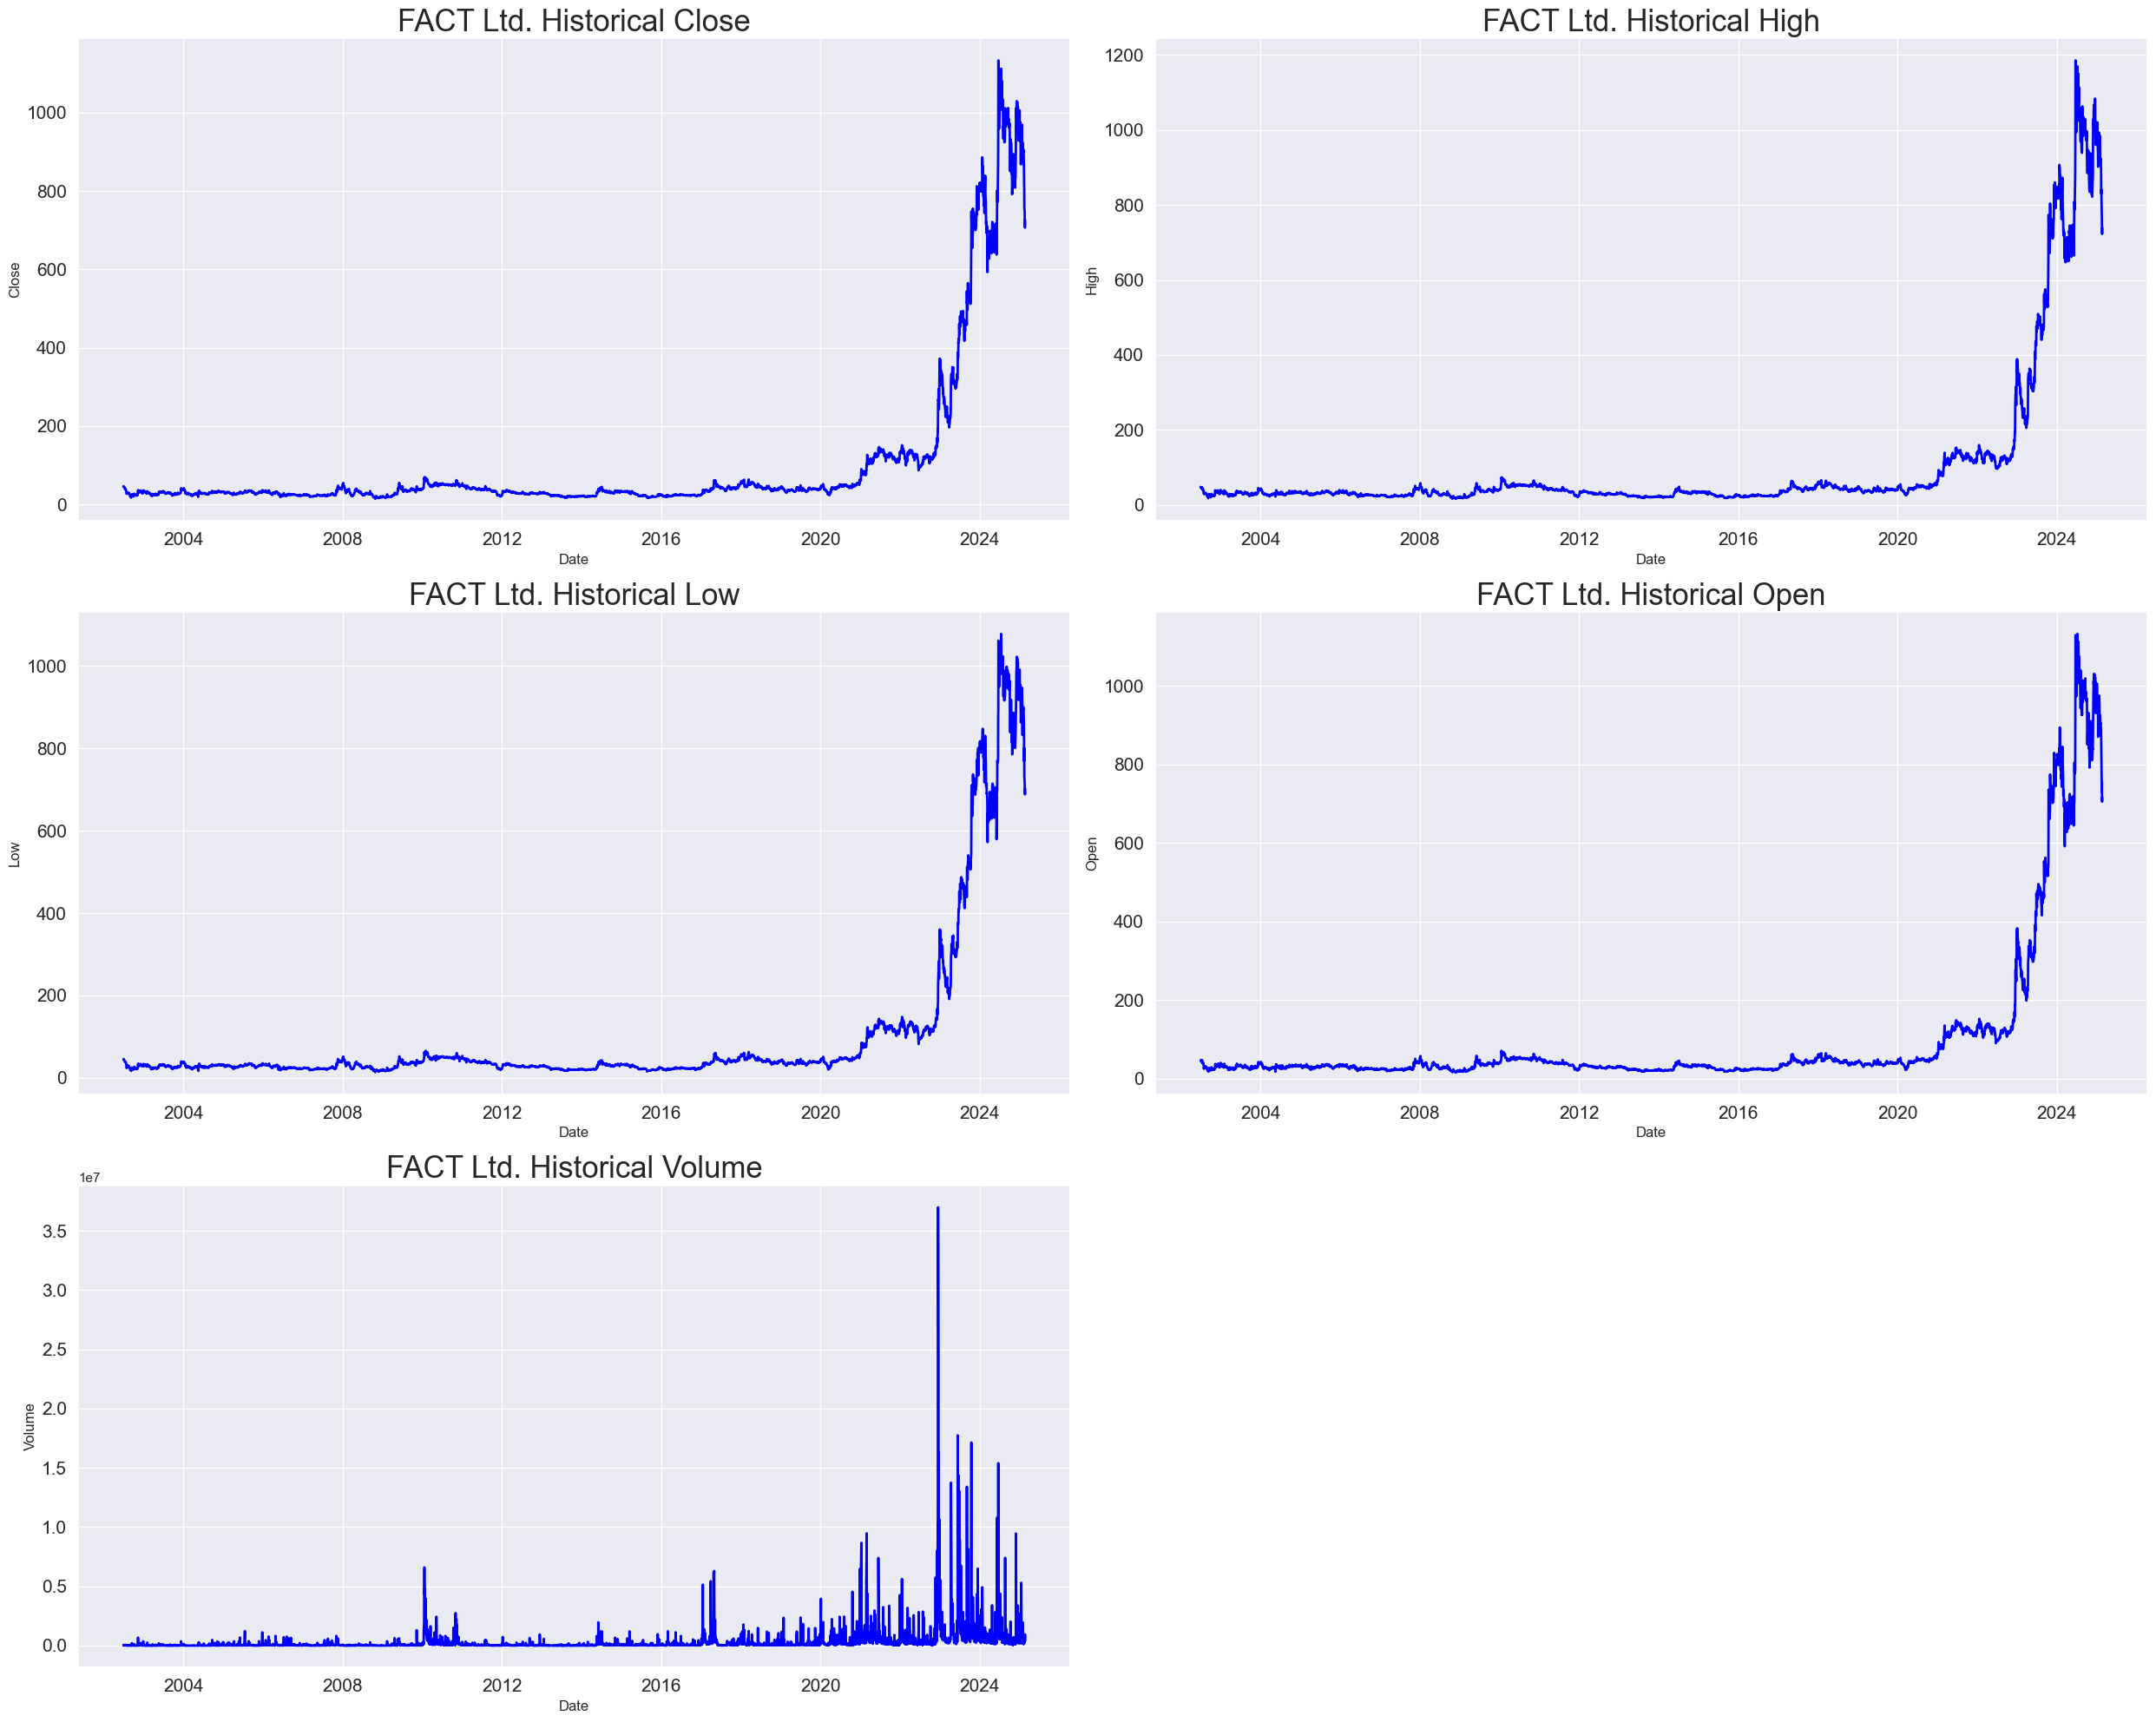

In [14]:
plt.figure(figsize=(25,20))
sns.set_theme(style='darkgrid')
for i,col in enumerate(stock_data.columns):
    plt.subplot(3,2,i+1)
    sns.lineplot(stock_data[col], color='blue', linewidth=2)
    plt.title(f"FACT Ltd. Historical {col}", fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.tight_layout()

The prices are relatively stagnant over the years with occassional jumps, but the real breakout seem to have begun after 2020.  
There is a definite uptrend for the stock price which is evident from the plot.  

The plots for Open, Close, High and Low seems to be identical except for very minor differences. As is the case with the stock market these prices do not deviate very far from each other on any usual day.

The volume data indicates strong trading interest in the stock during the recent years. There is a steady rise after 2020. Volume could be an important feature in forecasting the future prices.

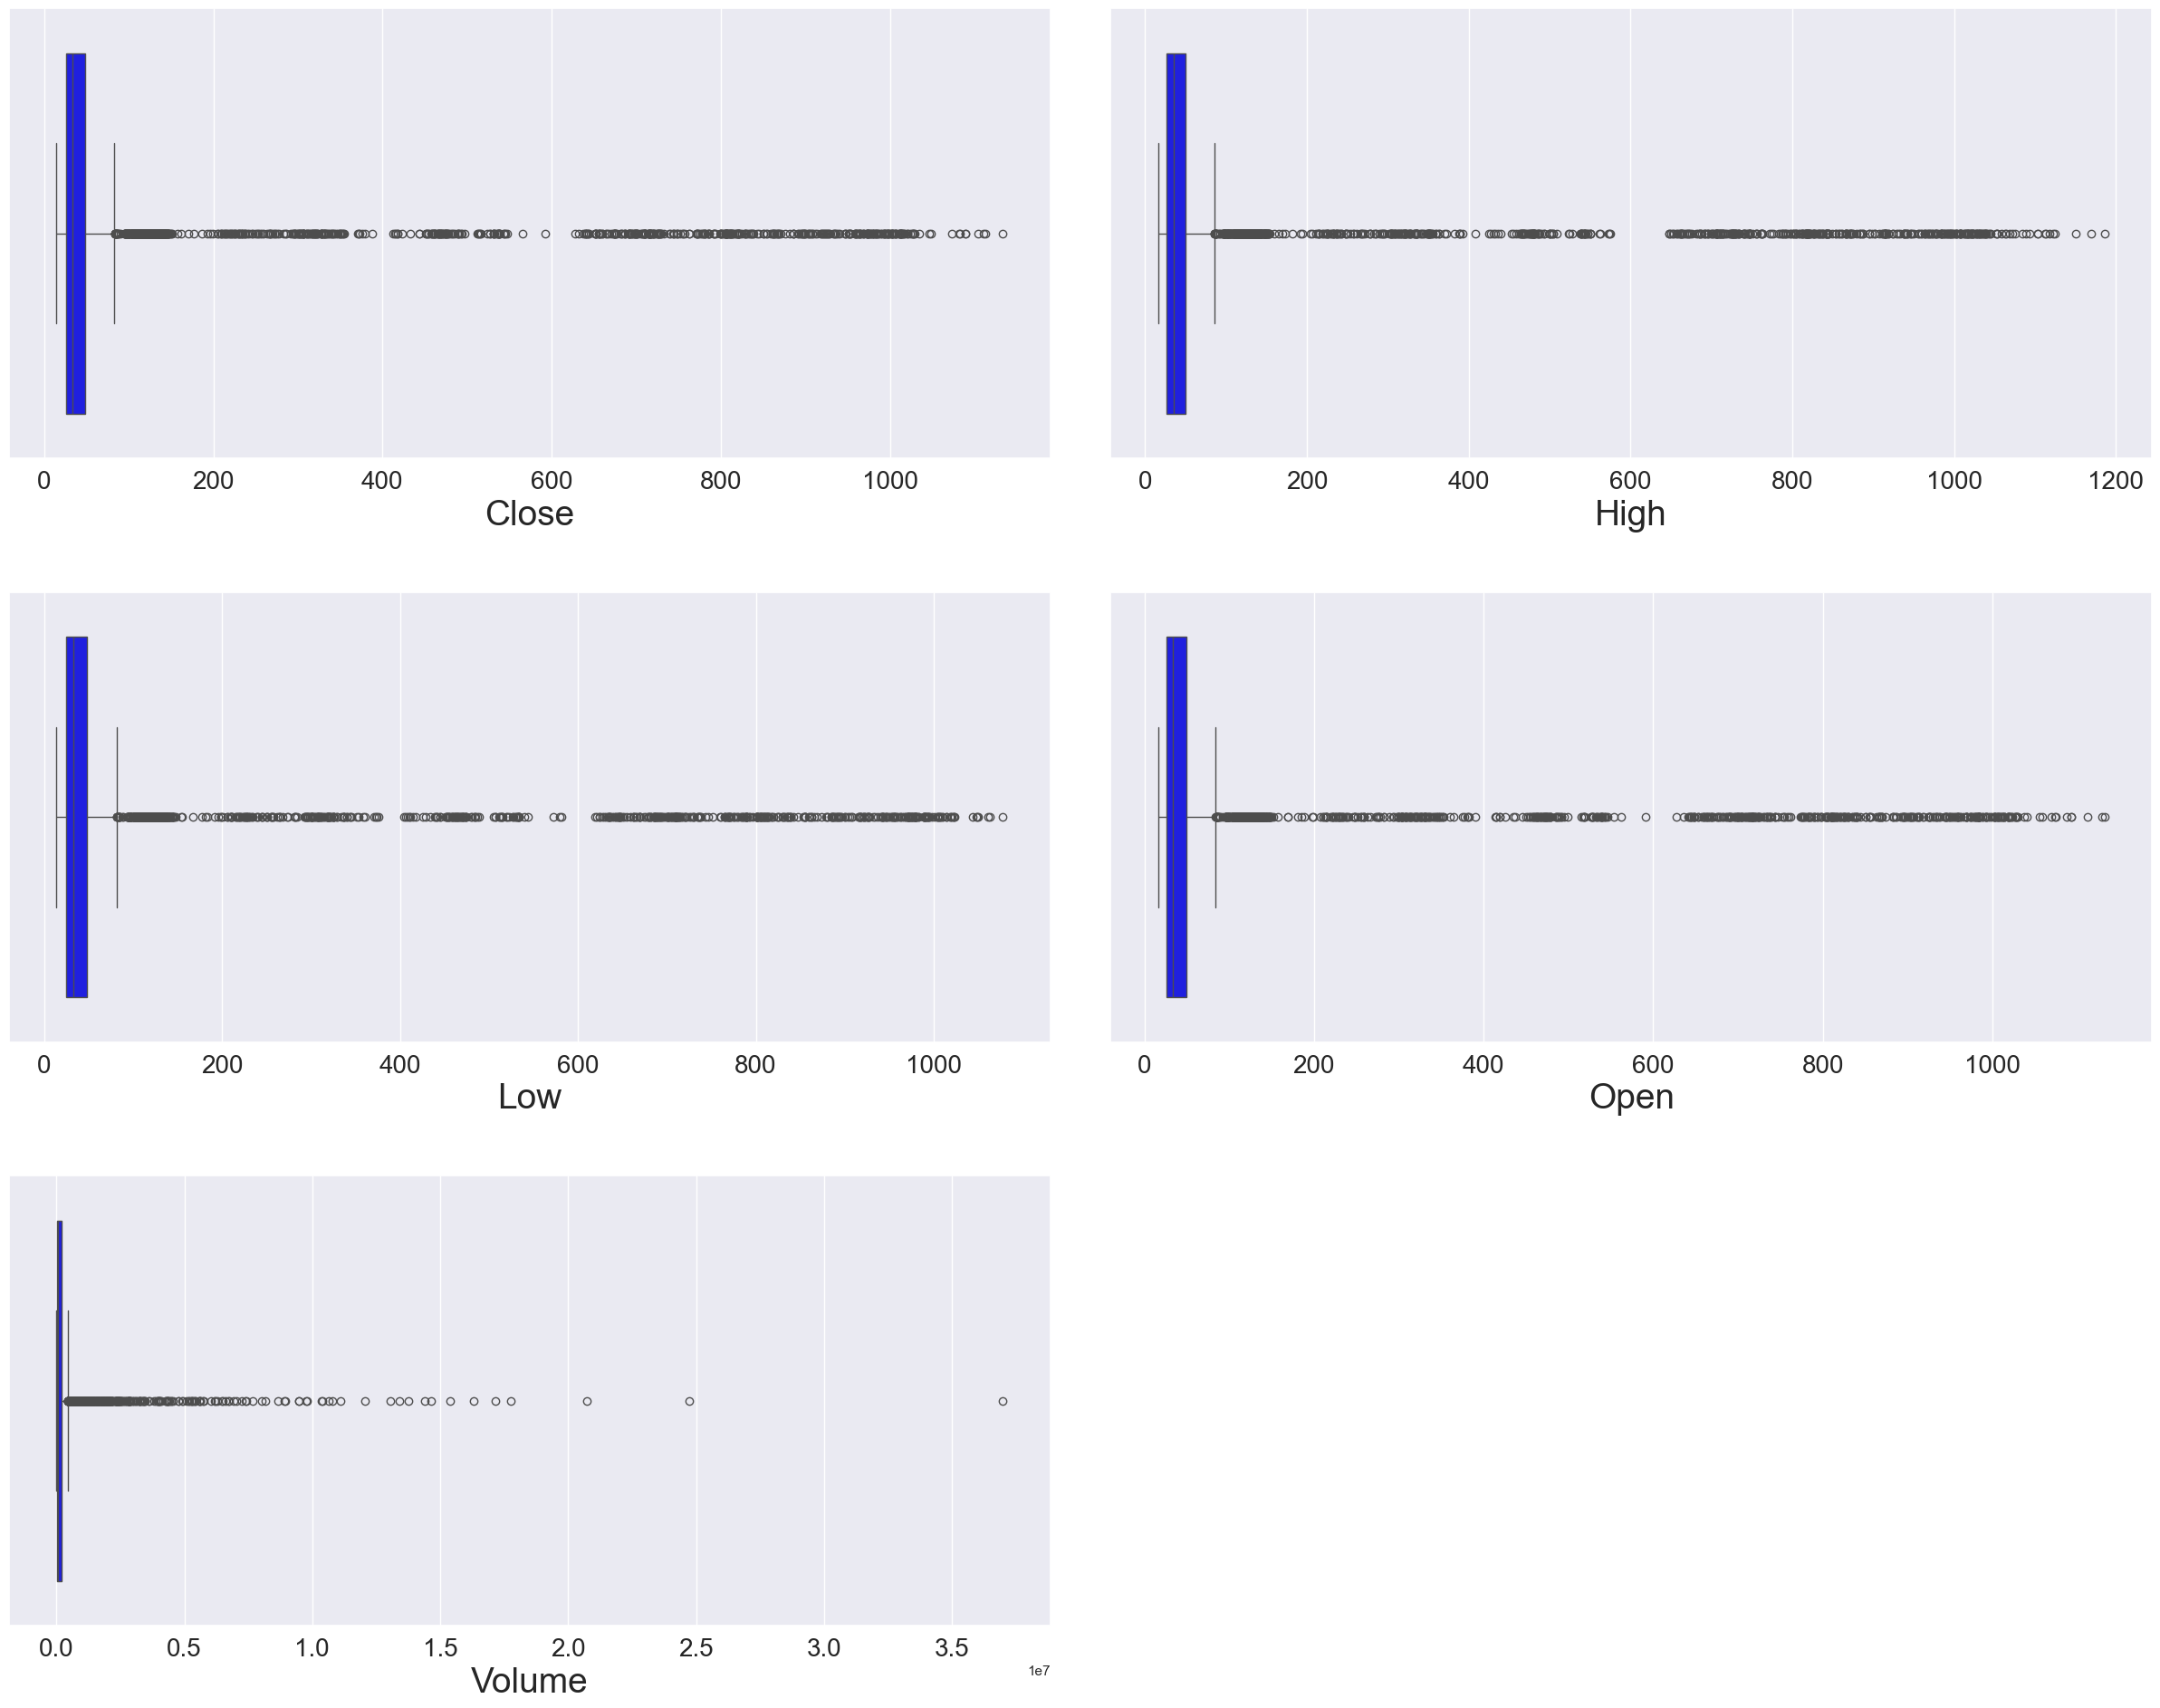

In [15]:
plt.figure(figsize=(25,20))
sns.set_theme(style="darkgrid")
for i,col in enumerate(stock_data.columns):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=stock_data[col], color='blue')
    plt.xlabel(col, fontsize=28)
    plt.xticks(fontsize=20)
plt.tight_layout(pad=4)

All the features have very extreme outliers in boxplots, but these outliers are not random noise but significant value increase over time.  
The extreme values in the Volume feature is verifying of the observation that a very high trading activity has been happening in recent times.

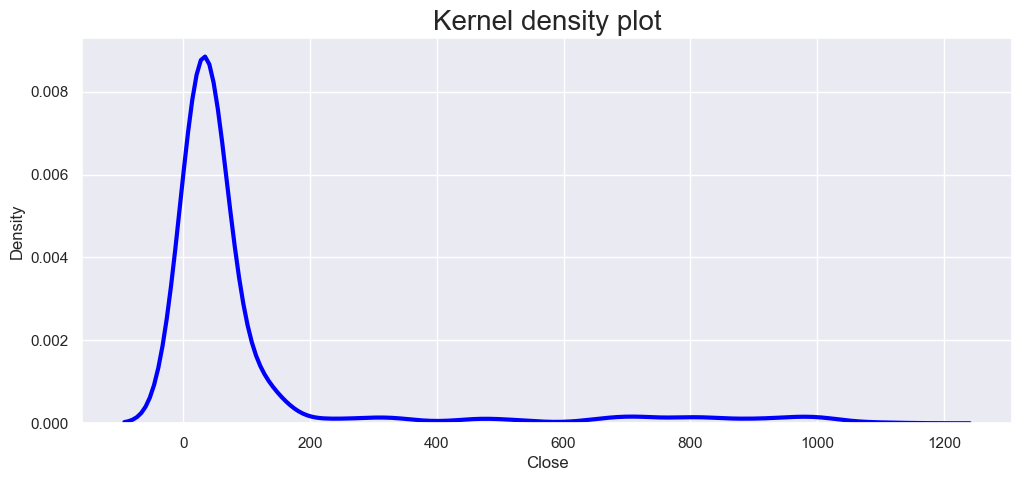

In [16]:
sns.kdeplot(stock_data["Close"], linewidth=3, color="blue")
plt.title("Kernel density plot", fontsize=20)
plt.show()

As seen from the plot of closing price itself, much of the data is concentrated in the lower price point of the data during is long period of relative stagnation, which is also verified by the KDE plot.

25 day Rolling mean and rolling standard-deviation of Closing price

In [17]:
def check_stationarity(feature:pd.Series):

    #rolling statistics
    rolmean = feature.rolling(50).mean()
    rolstd = feature.rolling(50).std()

    sns.lineplot(feature, color='blue', label=feature.name, linewidth=2)
    sns.lineplot(rolstd, color='orange', label='50 day rolling Std', linewidth=3)
    sns.lineplot(rolmean, color='red', linestyle='dashed', label='50 day rolling mean', linewidth=3)
    plt.legend(loc='best', fontsize = 12, shadow=True)
    plt.title(f"{feature.name} - Rolling mean & Standard Deviation", fontsize=20)
    plt.show()

    print("Results of adf test")
    print("="*50)
    adft = adfuller(feature, autolag='AIC')
    # output for adf test returns plain values
    # making the return values structured, with the proper headers

    output = pd.Series(adft[0:4],index=['adf test statistic','p-value','No. of lags used','Number of observations used'])
    for key,value in adft[4].items():
        output[f'critical value {key}'] =  value
    print(output)

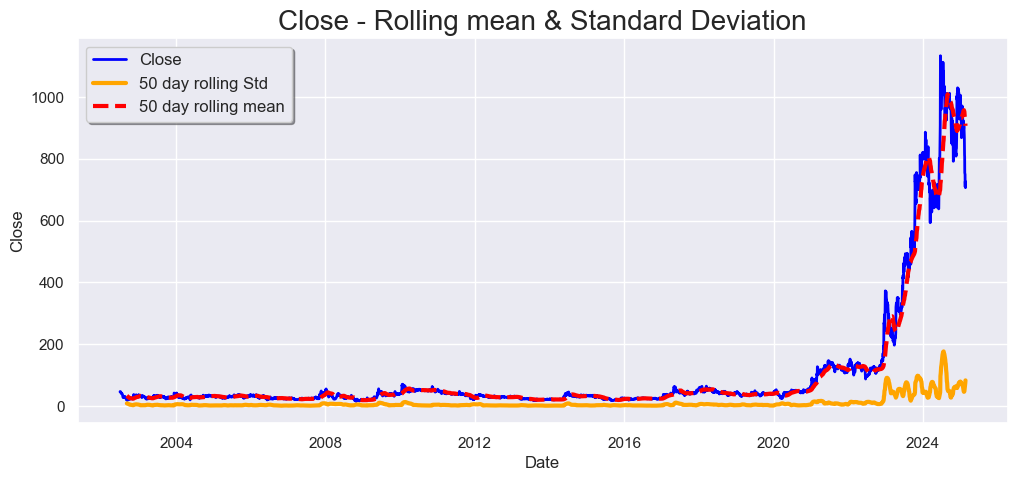

Results of adf test
adf test statistic                0.672789
p-value                           0.989279
No. of lags used                 33.000000
Number of observations used    5591.000000
critical value 1%                -3.431520
critical value 5%                -2.862057
critical value 10%               -2.567045
dtype: float64


In [18]:
# stationarity for Close price
check_stationarity(stock_data["Close"])

The graph of the data clearly shows the non-stationarity of the data and the Augmented Dickey Fuller test confirms that observation.  
We fail to reject the null hypothesis since the p-value returned is greater than 0.05 and the test statistic is greater than the critical value.

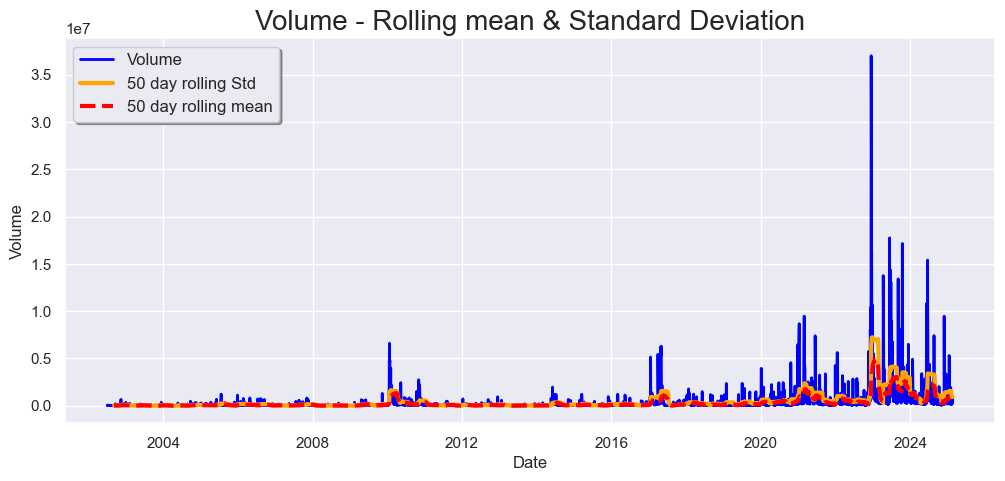

Results of adf test
adf test statistic            -1.009626e+01
p-value                        1.088872e-17
No. of lags used               2.400000e+01
Number of observations used    5.600000e+03
critical value 1%             -3.431518e+00
critical value 5%             -2.862056e+00
critical value 10%            -2.567045e+00
dtype: float64


In [19]:
# Stationarity for Volume feature
check_stationarity(stock_data['Volume'])

Similarly, the Volume feature is also non-stationary.  
p-value > 0.05  
ADF test statistic > critical value

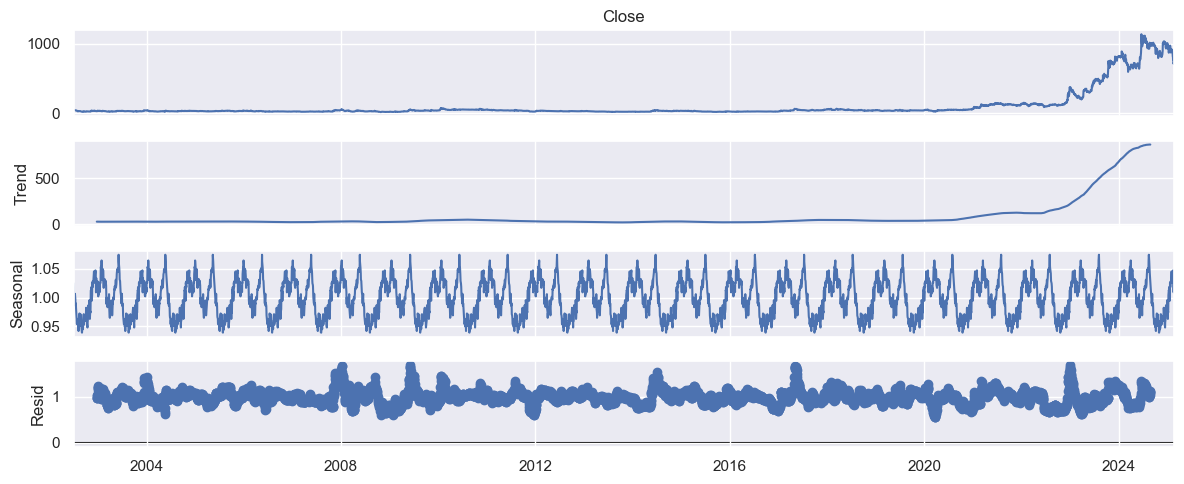

In [20]:
# choosing the sesason to be yearly
# A year typically have around 250 trading days, hence period=250

decomposition_close = seasonal_decompose(stock_data['Close'], model='multiplicative', period=250)
decomposition_close.plot()
plt.show()

The trend shows long term upward trend with some stagnation phase.  

The seasonal component shows recurring patterns, showing seasonality.  

The residuals seems to have varying variance, indicating heteroskedasticity.

#### ACF & PACF

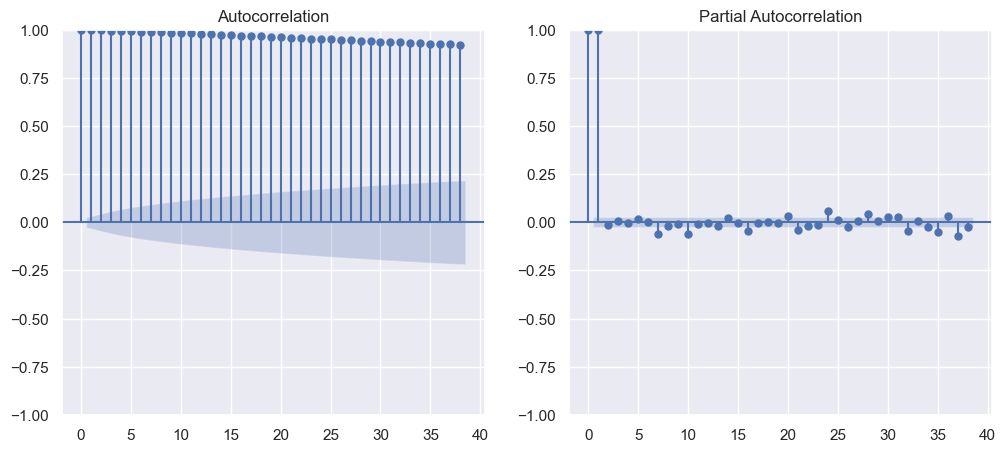

In [21]:
fig , (ax1,ax2) = plt.subplots(1,2)
plot_acf(stock_data['Close'], ax=ax1)
plot_pacf(stock_data['Close'], ax=ax2)
plt.show()

The steady tail off in ACF plot suggest significant long term correlations and the need for differencing the data (acf suggest non-stationarity).  

There is  cut off at 1 in PACF, suggesting strong correlation at lag1 and an AR(1) component.  
ie, p=1

#### Differencing

In [22]:
stock_close_diff = stock_data['Close'].diff().rename("Close price 1st diff")
stock_close_diff.dropna(inplace=True)

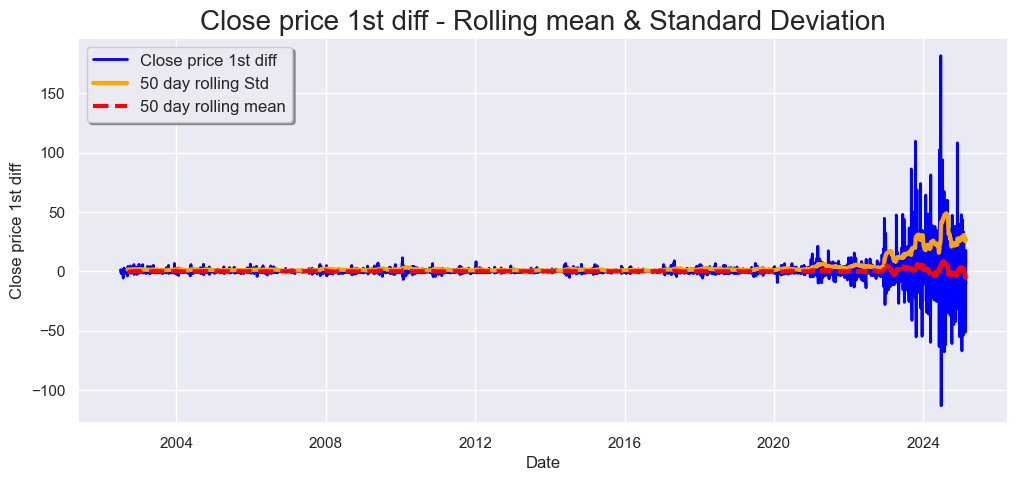

Results of adf test
adf test statistic            -1.320142e+01
p-value                        1.092472e-24
No. of lags used               3.300000e+01
Number of observations used    5.590000e+03
critical value 1%             -3.431520e+00
critical value 5%             -2.862057e+00
critical value 10%            -2.567045e+00
dtype: float64


In [23]:
check_stationarity(stock_close_diff)

  The adf test returns a p-value that is close to 0, and the test statistic is much lower than the critical value, hence we reject the null hypothesis, ie, the data is stationary.

since the data is made stationary after first differencing, d=1

## Model Training

In [24]:
# Train test split
train_data = stock_data['Close'][:-100]
test_data = stock_data['Close'][-100:]

In [25]:
train_data

Date
2002-07-01     45.318386
2002-07-02     46.465050
2002-07-03     46.365341
2002-07-04     46.116066
2002-07-05     45.717224
                 ...    
2024-09-25    978.500000
2024-09-26    967.500000
2024-09-27    960.799988
2024-09-30    963.950012
2024-10-01    973.000000
Name: Close, Length: 5525, dtype: float64

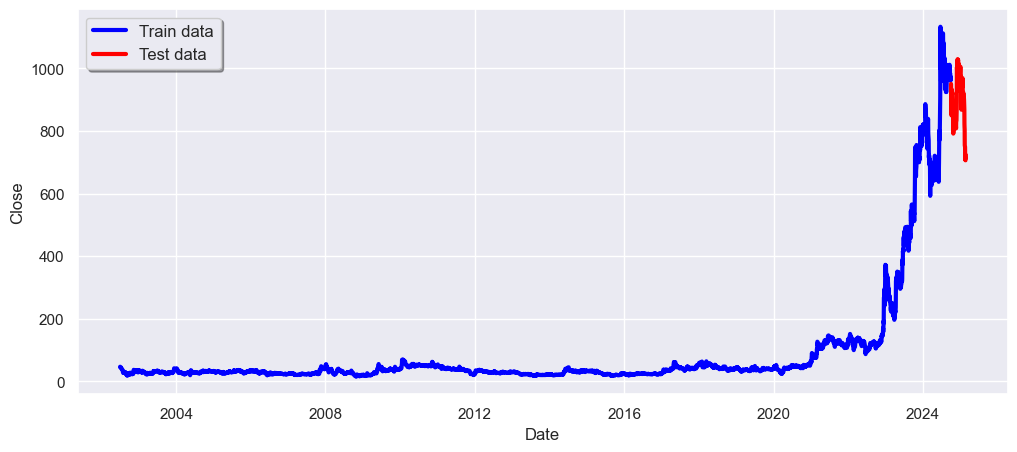

In [26]:
sns.lineplot(train_data, color="blue", label="Train data", linewidth=3)
sns.lineplot(test_data, color="red", label="Test data", linewidth=3)
plt.legend(loc='best', fontsize = 12, shadow=True)
plt.show()

### ARIMA

In [27]:
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import root_mean_squared_error

we observed the (p,d,q) order to be (1,1,0). We will train multiple models with different orders and see whether the observation is accurate or not.

Finding the best order for the ARIMA model

In [28]:
class ModelTraining:
    p_values = [0,1,2]
    d_values = [1]
    q_values = [0,1,2]

    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data

    def arima_model_performance(self, arima_order):
        """Returns (rmse, aic, bic)"""
        history = [x for x in self.train_data]
        # make predictions
        pred = list()
        for i in range(len(self.test_data)):
            model = ARIMA(history, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            yhat = model_fit.forecast()
            pred.append(yhat)
            history.append(self.test_data.iloc[i])
            
        # AIC and BIC    
        aic = model_fit.aic
        bic = model_fit.bic
        # calculate out of sample forecasting error
        rmse = root_mean_squared_error(test_data, pred)
        return rmse, aic, bic


    # evaluate combinations of p, d and q values for an ARIMA model
    def evaluate_model(self):
        best_score, best_order = float("inf"), None
        for p in self.p_values:
            for d in self.d_values:
                for q in self.q_values:
                    order = (p,d,q)
                    try:
                        rmse, aic, bic = self.arima_model_performance(order)
                        if rmse < best_score:
                            best_score, best_order = rmse, order
                        print(f"ARIMA order: {order} \t RMSE: {rmse}")
                        print(f"AIC: {aic} \t BIC: {bic}\n\n")
                    except:
                        continue
        print("="*50)
        print(f"Best ARIMA: {best_order} \t RMSE: {best_score}")

In [29]:
model_trainer = ModelTraining(train_data=train_data, test_data=test_data)
model_trainer.evaluate_model()

ARIMA order: (0, 1, 0) 	 RMSE: 27.28573164703857
AIC: 39334.42064779756 	 BIC: 39341.05509054902


ARIMA order: (0, 1, 1) 	 RMSE: 27.312680572056244
AIC: 39329.883376557336 	 BIC: 39343.15190628334


ARIMA order: (0, 1, 2) 	 RMSE: 27.489940850164782
AIC: 39316.12701889347 	 BIC: 39336.029279722134


ARIMA order: (1, 1, 0) 	 RMSE: 27.31024774617163
AIC: 39335.91932326601 	 BIC: 39349.188208768945


ARIMA order: (1, 1, 1) 	 RMSE: 27.281622773609545
AIC: 39297.561281724906 	 BIC: 39317.46407631391


ARIMA order: (1, 1, 2) 	 RMSE: 27.414190266774742
AIC: 39285.50598905061 	 BIC: 39312.04233682216


ARIMA order: (2, 1, 0) 	 RMSE: 27.443010016871103
AIC: 39324.42227526066 	 BIC: 39344.32506984966


ARIMA order: (2, 1, 1) 	 RMSE: 27.42411209863241
AIC: 39291.548801218654 	 BIC: 39318.08586067066


ARIMA order: (2, 1, 2) 	 RMSE: 27.44340487847761
AIC: 39288.5061335082 	 BIC: 39321.67656822264


Best ARIMA: (1, 1, 1) 	 RMSE: 27.281622773609545


The best order for ARIMA is (1,1,1)

In [30]:
# Date as index will raise warning without a frequency in the datetime
history = [x for x in train_data]
prediction = list()

for i in range(len(test_data)):
    model = ARIMA(history, order=(1,1,1), enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit()
    yhat, = model_fit.forecast()
    prediction.append(yhat)
    history.append(test_data.iloc[i])

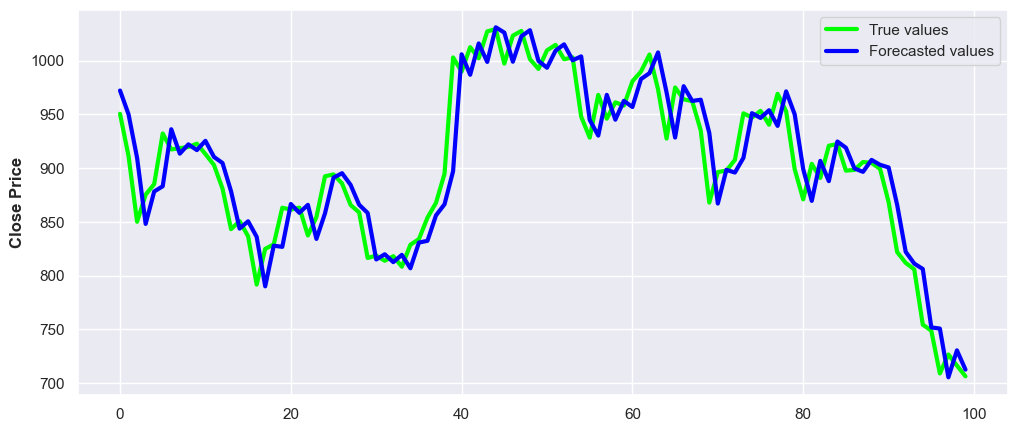

In [31]:
sns.lineplot(test_data.values, label="True values", color="lime", linewidth=3)
sns.lineplot(prediction, label="Forecasted values", color="blue", linewidth=3)
plt.ylabel("Close Price", weight='bold')
plt.show()

### SARIMAX

In [32]:
from statsmodels.tsa.api import SARIMAX

In [33]:
data = stock_data[['Close', 'Volume']]

In [79]:
def sarimax_forecast(data):
    train_data = data.iloc[:-100]
    test_data = data.iloc[-100:]
    
    price_history = [x for x in train_data['Close']]
    volume_history = [x for x in train_data['Volume']]
    test_data_price = test_data['Close']
    test_data_volume = test_data['Volume']
    prediction = list()

    for i in range(len(test_data)):
        # seasonal order can be passed if necessary, now training model with just the exogeneous variable
        model = SARIMAX(price_history, exog=volume_history, order=(1,1,1),
                        enforce_invertibility=False, enforce_stationarity=False)
        model_fit = model.fit(method="powell", disp=False)
        yhat, = model_fit.forecast(exog=test_data_volume.iloc[i])
        prediction.append(yhat)
        price_history.append(test_data_price.iloc[i])
        volume_history.append(test_data_volume.iloc[i])
    
    rmse = root_mean_squared_error(test_data['Close'], prediction)
    aic = model_fit.aic
    bic = model_fit.bic
    print(f"RMSE: {rmse} \t AIC: {aic} \t BIC: {bic}")

    sns.lineplot(test_data_price.values, label="True value", color="lime", linewidth=3)
    sns.lineplot(prediction, label="Forecasted value", color="blue", linewidth=3)
    plt.ylabel("Close Price", weight='bold')
    plt.show()

RMSE: 25.369132830959334 	 AIC: 38080.914215527606 	 BIC: 38107.45127497961


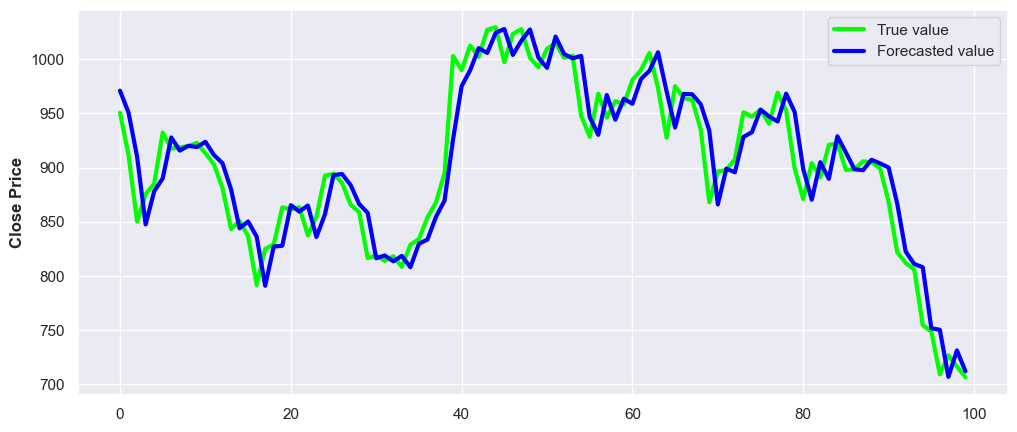

In [80]:
sarimax_forecast(data)

The SARIMAX model has a lower RMSE and AIC than the ARIMA model.

### PROPHET

In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv("../Data/FACT-stockprice-history.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5625 non-null   object 
 1   Close   5625 non-null   float64
 2   High    5625 non-null   float64
 3   Low     5625 non-null   float64
 4   Open    5625 non-null   float64
 5   Volume  5625 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 263.8+ KB


In [5]:
# since prophet is a univariate model, we will use only the Close price
df = df[["Date", "Close"]]
df.head()

,Date,Close
0,2002-07-01,45.318386
1,2002-07-02,46.465050
2,2002-07-03,46.365341
3,2002-07-04,46.116066
4,2002-07-05,45.717224


In [6]:
#converting Date to datetime format, renaming columns to the specification of the prophet library
# and removing any other columns in the dataframe

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.rename(columns={"Close":"y", "Date":"ds"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5625 non-null   datetime64[ns]
 1   y       5625 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 88.0 KB


In [7]:
train_df, test_df = df.iloc[:-100], df.iloc[-100:]
train_df

,ds,y
0,2002-07-01,45.318386
1,2002-07-02,46.465050
2,2002-07-03,46.365341
3,2002-07-04,46.116066
4,2002-07-05,45.717224
...,...,...
5520,2024-09-25,978.500000
5521,2024-09-26,967.500000
5522,2024-09-27,960.799988
5523,2024-09-30,963.950012


In [8]:
model = Prophet()
model.fit(train_df)

18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Predicting the target value in the dates of the train data, thereby giving the model fit
train_forecast = model.predict(train_df[['ds']])

# prediction along the test data
test_forecast = model.predict(test_df[['ds']])

In [10]:
train_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-07-01,43.742037,-47.115925,124.738053,43.742037,43.742037,-5.092003,-5.092003,-5.092003,-17.037850,-17.037850,-17.037850,11.945847,11.945847,11.945847,0.0,0.0,0.0,38.650033
1,2002-07-02,43.742585,-35.719124,124.000415,43.742585,43.742585,-3.193376,-3.193376,-3.193376,-15.414771,-15.414771,-15.414771,12.221396,12.221396,12.221396,0.0,0.0,0.0,40.549209
2,2002-07-03,43.743133,-45.781655,125.961056,43.743133,43.743133,-3.473998,-3.473998,-3.473998,-15.899204,-15.899204,-15.899204,12.425206,12.425206,12.425206,0.0,0.0,0.0,40.269136
3,2002-07-04,43.743681,-46.729916,126.211798,43.743681,43.743681,-3.197402,-3.197402,-3.197402,-15.756395,-15.756395,-15.756395,12.558993,12.558993,12.558993,0.0,0.0,0.0,40.546279
4,2002-07-05,43.744229,-48.732588,129.695929,43.744229,43.744229,-3.513524,-3.513524,-3.513524,-16.138966,-16.138966,-16.138966,12.625442,12.625442,12.625442,0.0,0.0,0.0,40.230705


In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_df['ds'],
    y=train_df['y'],
    mode='lines',
    name='Training Data',  # Name for legend
    line=dict(color='blue', width=3)  # Custom color/width
))

fig.add_trace(go.Scatter(
    x=train_forecast['ds'],
    y=train_forecast['yhat'],
    mode='lines',
    name='Model Forecast',  # Name for legend
    line=dict(color='red', width=3)  # Custom color/width
))

fig.update_layout(
    title='<b>Model Fit - Train data vs Forecasted Values</b>',
    xaxis_title='Date',
    yaxis_title='Close Price'
)

fig.show()

In [17]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    name='Confidence Interval',
    x=test_forecast['ds'],
    y=test_forecast['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig2.add_trace(go.Scatter(
    name='Confidence Interval',
    x=test_forecast['ds'],
    y=test_forecast['yhat_lower'],
    mode='lines',
    line=dict(width=0),
    marker=dict(color='green'),
    fill='tonexty',
    fillcolor='rgba(250,170,230, 0.4)'
))

fig2.add_trace(go.Scatter(
    x=test_forecast['ds'],
    y=test_forecast['yhat'],
    mode='lines',
    name='Model Forecast',
    line=dict(color='red', width=4)
))

fig2.add_trace(go.Scatter(
    x=test_df['ds'],
    y=test_df['y'],
    mode='lines',
    name='Test Data',
    line=dict(color='blue', width=4)
))

fig2.update_layout(
    title='<b>Test Data vs Model Prediction</b>',
    xaxis_title='Date',
    yaxis_title='Close Price'
)

fig2.show()